In [ ]:
# load the data here
# constact us for the dataset or use your own

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
# load the dataset
with open('backup_file','r') as f:
    lines = f.readlines()

with open('backup_file', 'w') as f:
     for i, line in enumerate(lines):
        if i == 0:
            f.write('Station_id, Date, Time, Humidity, Temperature, Pressure, Direction, Rainfall, Speed')
        f.write(line)


In [4]:

dataset = pd.read_csv("backup_file")

# convert to datetime series
dataset['Datetime'] = dataset[' Date'] + ' ' + dataset[' Time']
dataset[' Date'] = pd.to_datetime(dataset[' Date'])
dataset[' Time'] = pd.to_datetime(dataset[' Time'])
dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])

# keep only data from st00 and only from December (since these are clean)
dataset.drop(dataset[dataset['Station_id'] == "st01"].index, inplace=True)
dataset.drop(dataset[dataset[' Date'] < "2023-12-1"].index, inplace=True)
dataset.drop(dataset[dataset[' Date'] > "2024-01-01"].index, inplace=True)

# remove unwanted features
del dataset[' Date']
del dataset[' Time']
del dataset['Station_id']
del dataset[' Direction']
del dataset[' Rainfall']

dataset.head()
#dataset.tail()

,Humidity,Temperature,Pressure,Speed,Datetime
141,71.3,10.6,1014.77,4.20,2023-12-01 00:03:48
142,71.6,10.1,1014.64,8.05,2023-12-01 00:09:02
143,72.5,9.9,1014.67,9.08,2023-12-01 00:14:15
144,74.1,9.3,1014.75,4.20,2023-12-01 00:19:28
145,75.7,9.3,1014.76,9.36,2023-12-01 00:24:42


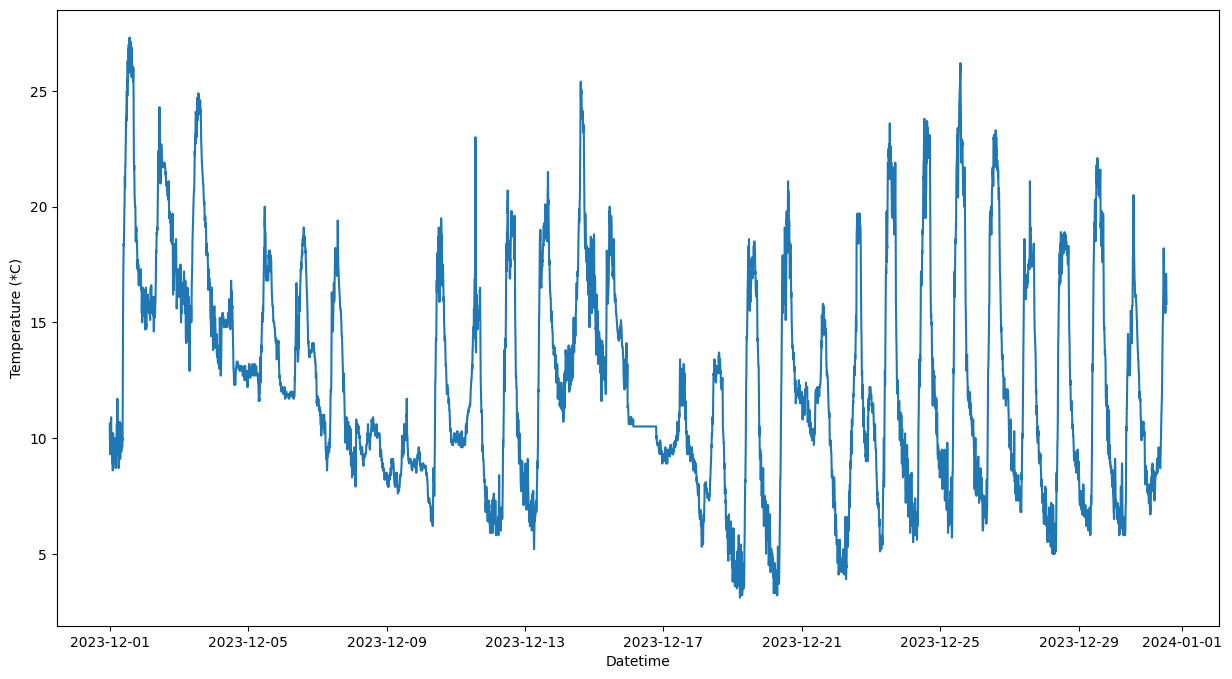

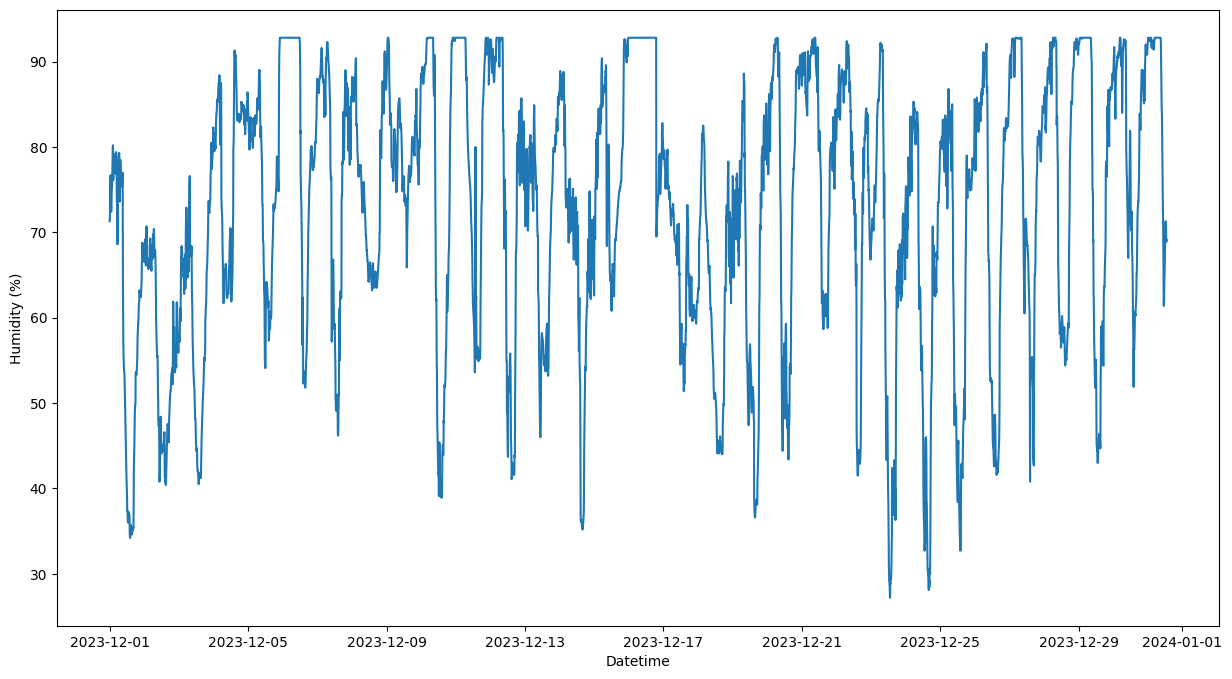

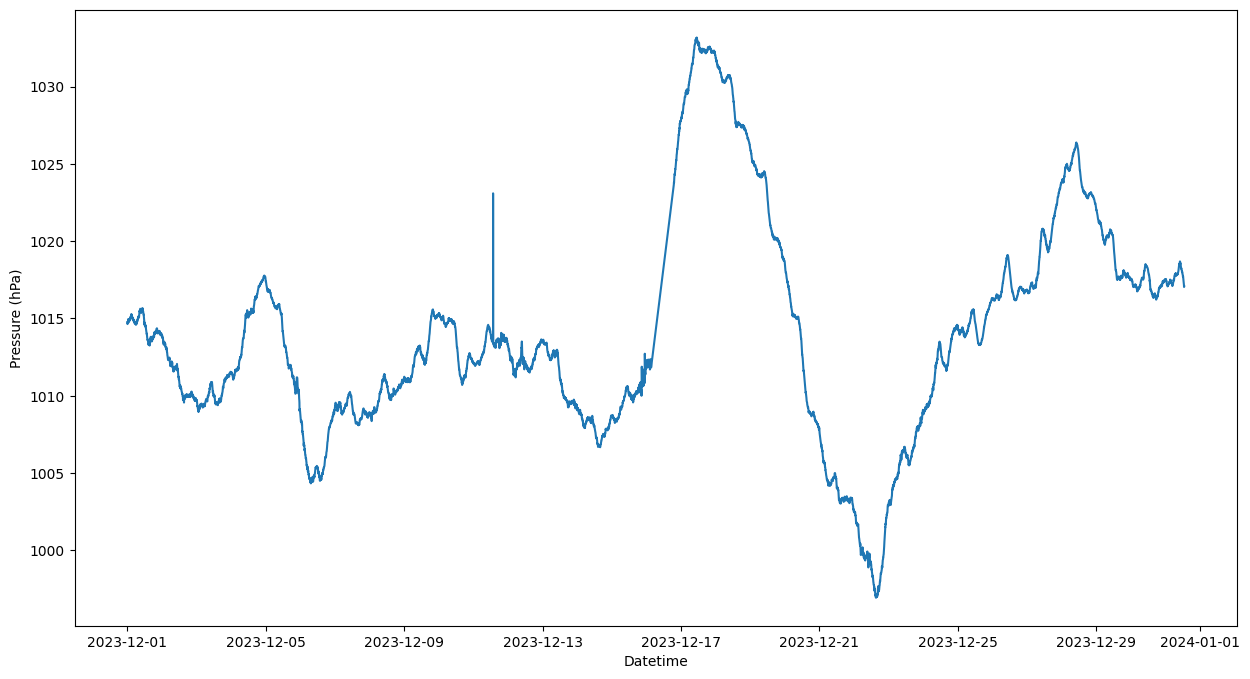

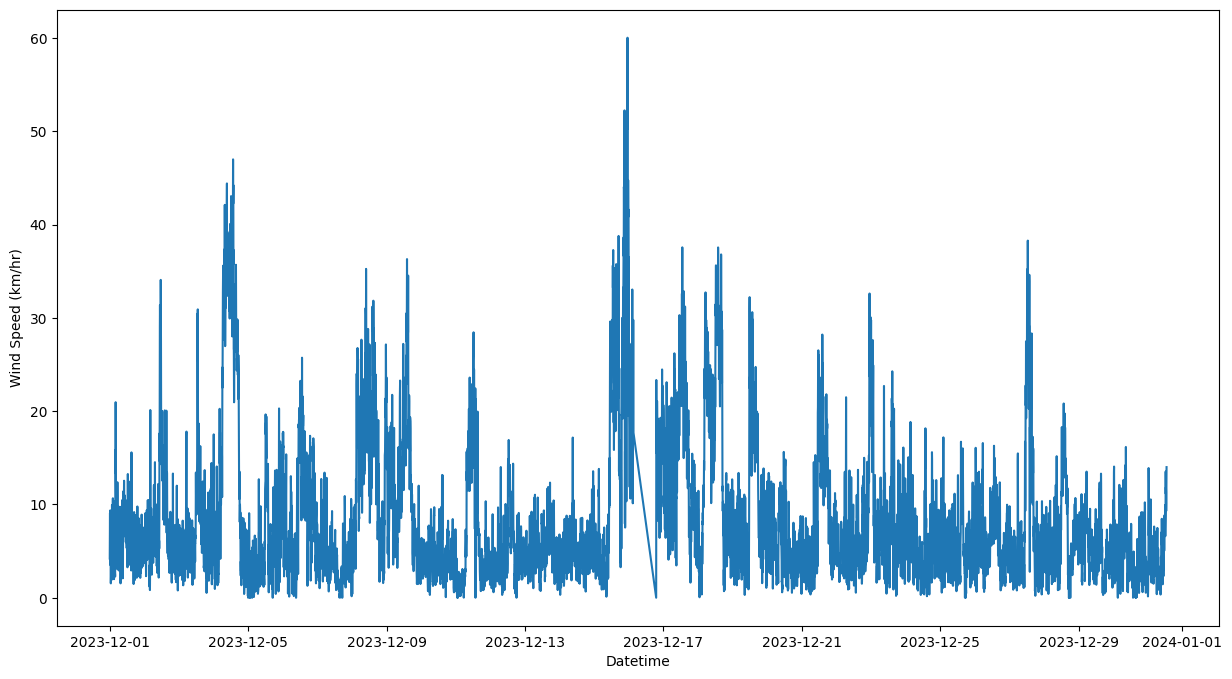

In [5]:
# visualize data
Datetime = dataset['Datetime'].values
T  = dataset[' Temperature'].values
RH = dataset[' Humidity'].values
P  = dataset[' Pressure'].values
V  = dataset[' Speed'].values

plt.figure(figsize=(15,8))
plt.plot(Datetime, T)
plt.xlabel("Datetime")
plt.ylabel("Temperature (*C)")
plt.show()

plt.figure(figsize=(15,8))
plt.plot(Datetime, RH)
plt.xlabel("Datetime")
plt.ylabel("Humidity (%)")
plt.show()

plt.figure(figsize=(15,8))
plt.plot(Datetime, P)
plt.xlabel("Datetime")
plt.ylabel("Pressure (hPa)")
plt.show()

plt.figure(figsize=(15,8))
plt.plot(Datetime, V)
plt.xlabel("Datetime")
plt.ylabel("Wind Speed (km/hr)")
plt.show()

In [6]:
# configure the dataset that will be used for training and testing
trainDataset = pd.DataFrame(T, columns=['Temperature',])
trainDataset['Humidity'] = RH
trainDataset['Pressure'] = P
trainDataset['Speed']    = V

trainSize = int(len(trainDataset) * 0.8)
testSize  = len(trainDataset) - trainSize

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainDataset = scaler.fit_transform(trainDataset)

# split it into train and test
train, test = trainDataset[0:trainSize, :], trainDataset[trainSize:len(trainDataset), :]

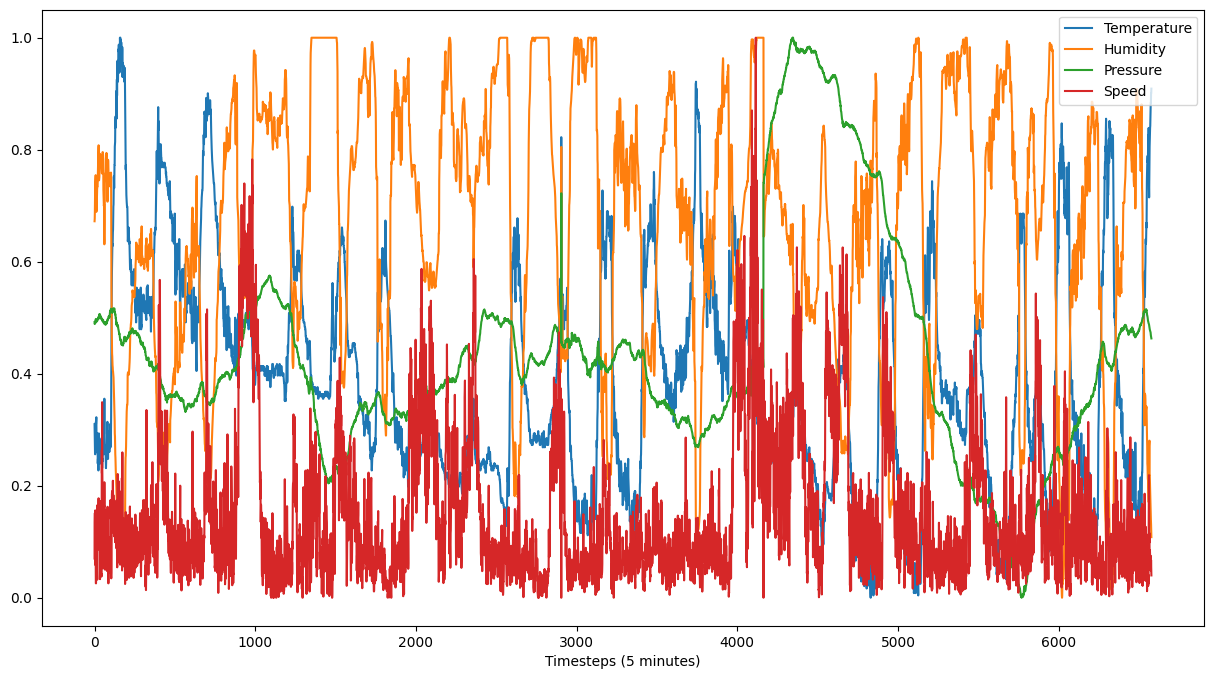

In [7]:
# visualize transformed data
train_df = pd.DataFrame(train, columns=['Temperature', 'Humidity', 'Pressure', 'Speed'])
test_df = pd.DataFrame(train, columns=['Temperature', 'Humidity', 'Pressure', 'Speed'])

plt.figure(figsize=(15,8))
plt.plot(train_df['Temperature'].values)
plt.plot(train_df['Humidity'].values)
plt.plot(train_df['Pressure'].values)
plt.plot(train_df['Speed'].values)
plt.legend(["Temperature", 'Humidity', 'Pressure', 'Speed'])
plt.xlabel("Timesteps (5 minutes)")
plt.show()

In [8]:
def create_sequence(dataset, timesteps, window):
    ''' remember `timestep` samples and try to predict `timestep` in future'''
    X, y = [], []
    for i in range(len(dataset)-timesteps-window-1):
        a = dataset[i:timesteps+i, :]
        X.append(a)
        y.append(dataset[i+timesteps+window, :])

    return np.array(X), np.array(y)

timesteps = 48 # 2 hours look-back window - 2 hours forward prediction
window    = 6
trainX, train_y = create_sequence(train, timesteps, window)
testX, test_y = create_sequence(test, timesteps, window)

# resize input sequences -> 3D tensors
train_X = np.reshape(trainX, (trainX.shape[0], 4, trainX.shape[1]))
test_X = np.reshape(testX, (testX.shape[0], 4, testX.shape[1]))

# verify the tensors shapes
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(6523, 4, 48)
(1590, 4, 48)
(6523, 4)
(1590, 4)


In [9]:
# construct the model

model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(4, timesteps), return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(4))

print(model.summary())

# train the model on the provided data
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(train_X, train_y, epochs=50, batch_size=64, verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            90624     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 140292 (548.02 KB)
Trainable params: 140292 (548.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
102/102 [==============================] - 8s 31ms/step - loss: 0.0266
Epoch 2/50
102/102 [==============================] - 4s 36ms

204/204 [==============================] - 2s 4ms/step


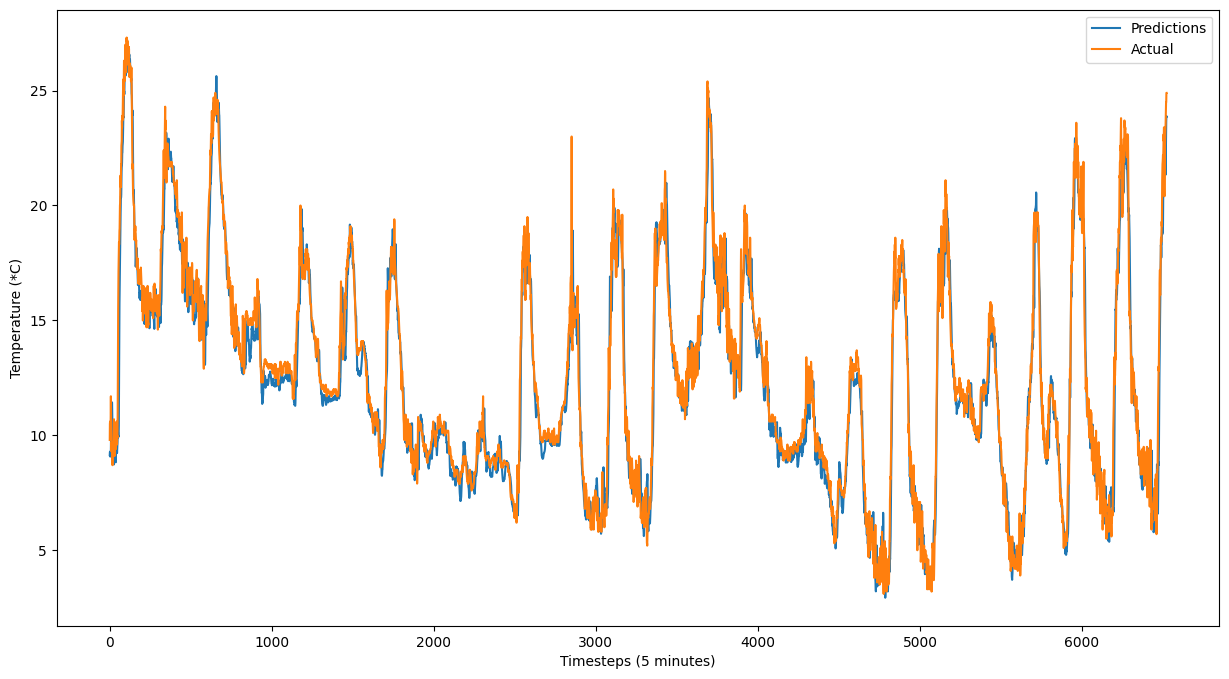

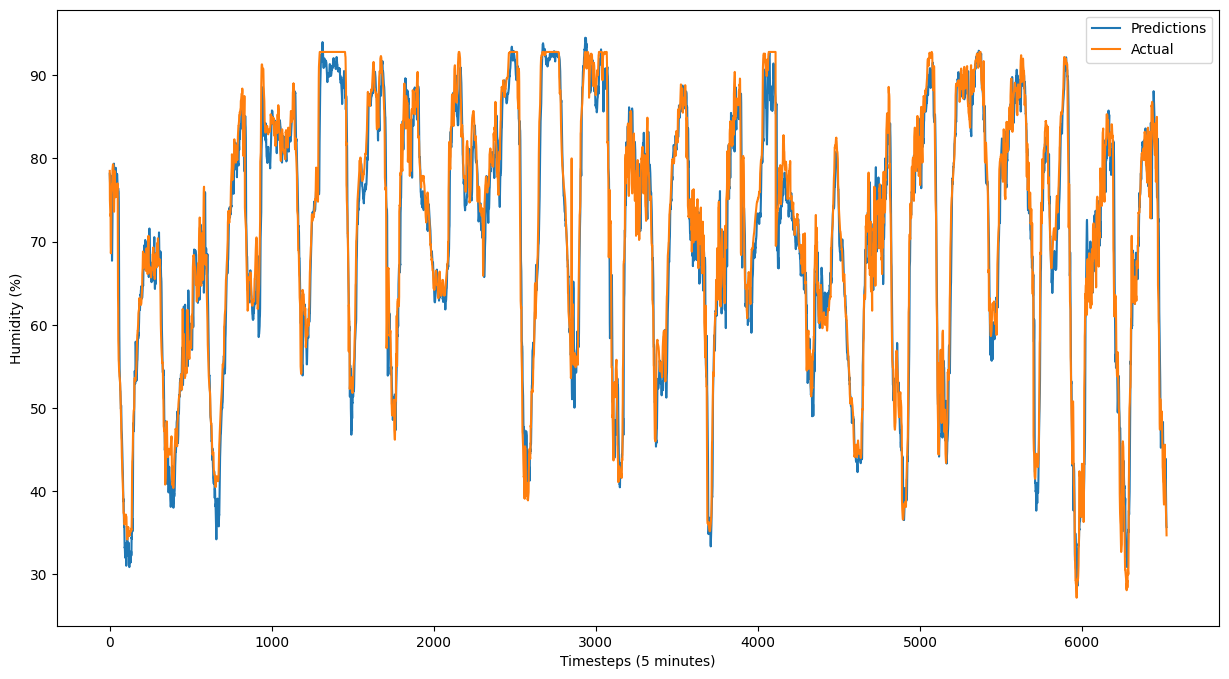

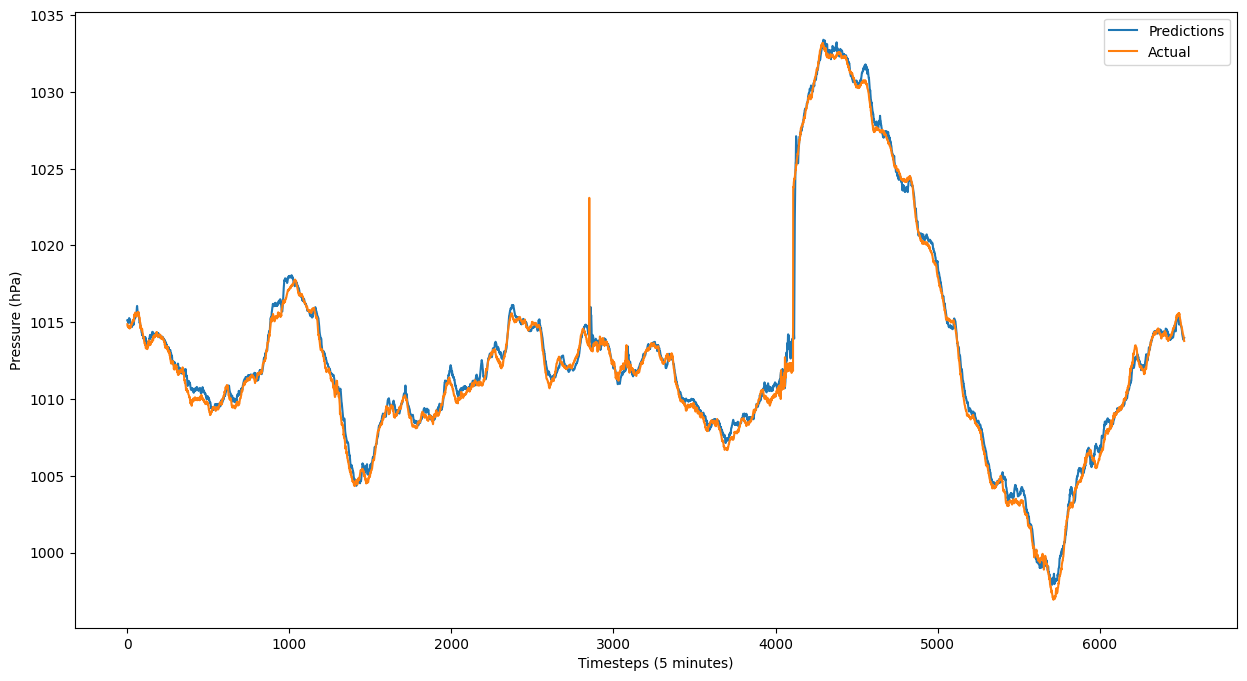

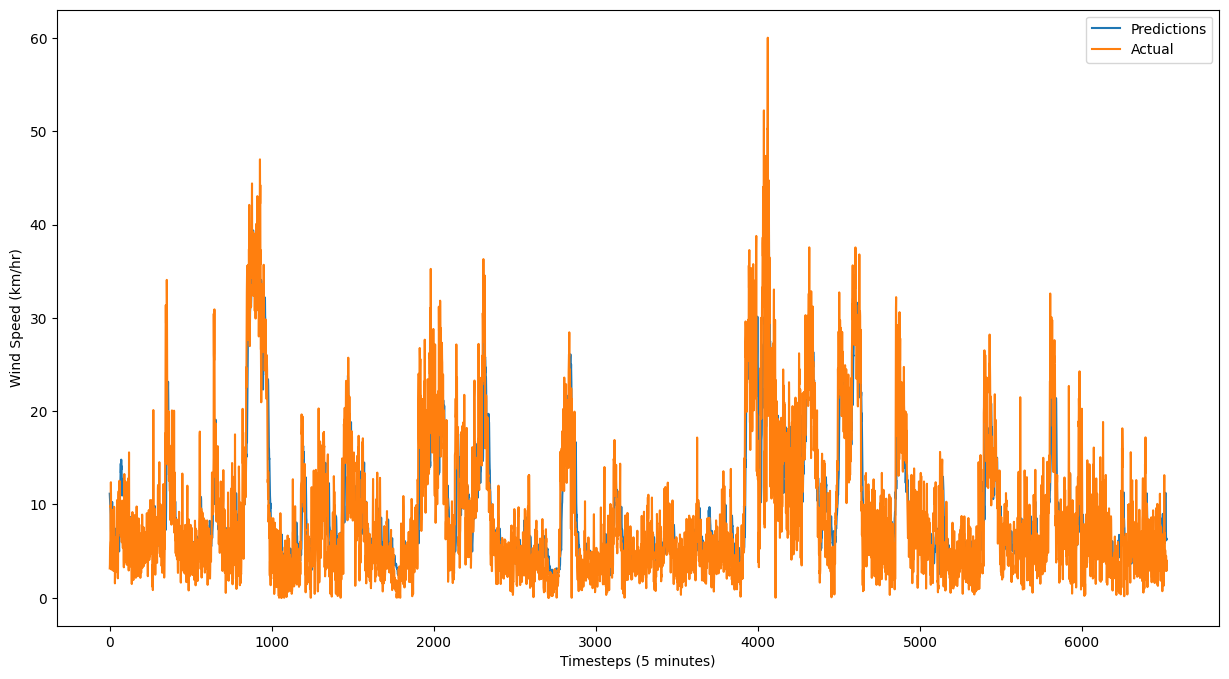

In [10]:
# make predictions on training set -> test for underfiting

train_pred = model.predict(train_X)
train_pred = scaler.inverse_transform(train_pred)
train_y_i  = scaler.inverse_transform(train_y)

# plot results for testing
plt.figure(figsize=(15,8))
plt.plot(train_pred[:,0])
plt.plot(train_y_i[:,0])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Temperature (*C)")
plt.legend(['Predictions', 'Actual'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(train_pred[:,1])
plt.plot(train_y_i[:,1])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Humidity (%)")
plt.legend(['Predictions', 'Actual'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(train_pred[:,2])
plt.plot(train_y_i[:,2])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Pressure (hPa)")
plt.legend(['Predictions', 'Actual'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(train_pred[:,3])
plt.plot(train_y_i[:,3])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Wind Speed (km/hr)")
plt.legend(['Predictions', 'Actual'])
plt.show()

50/50 [==============================] - 0s 4ms/step


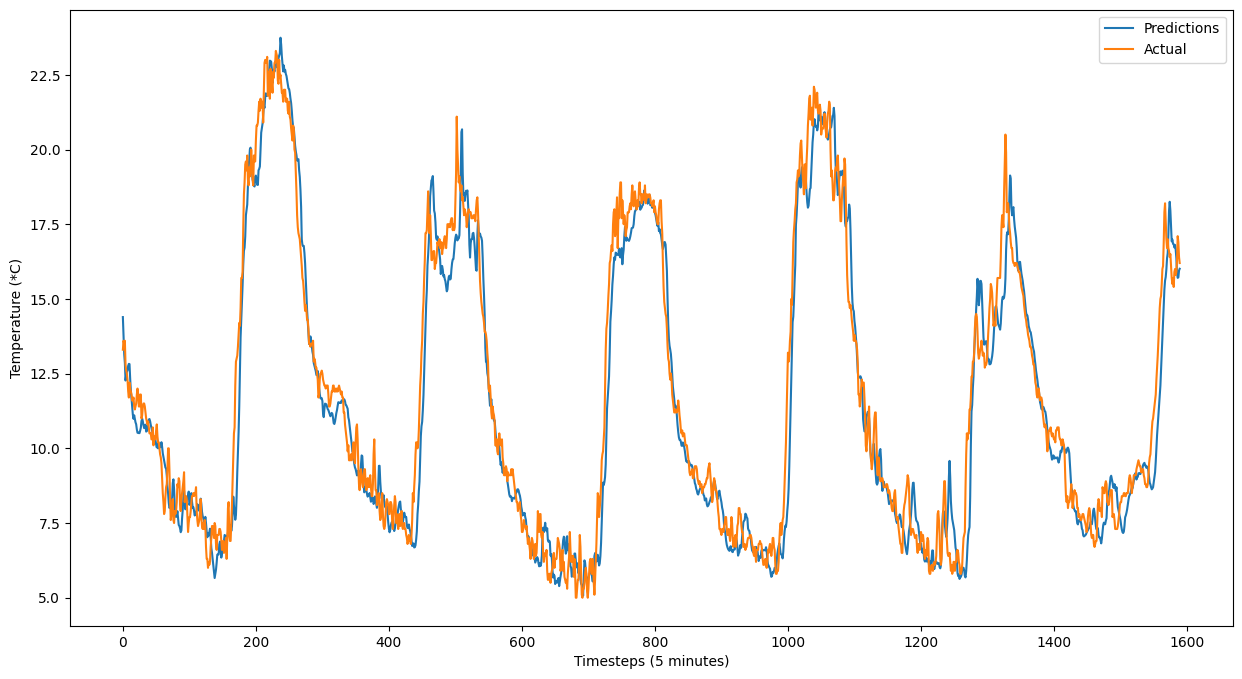

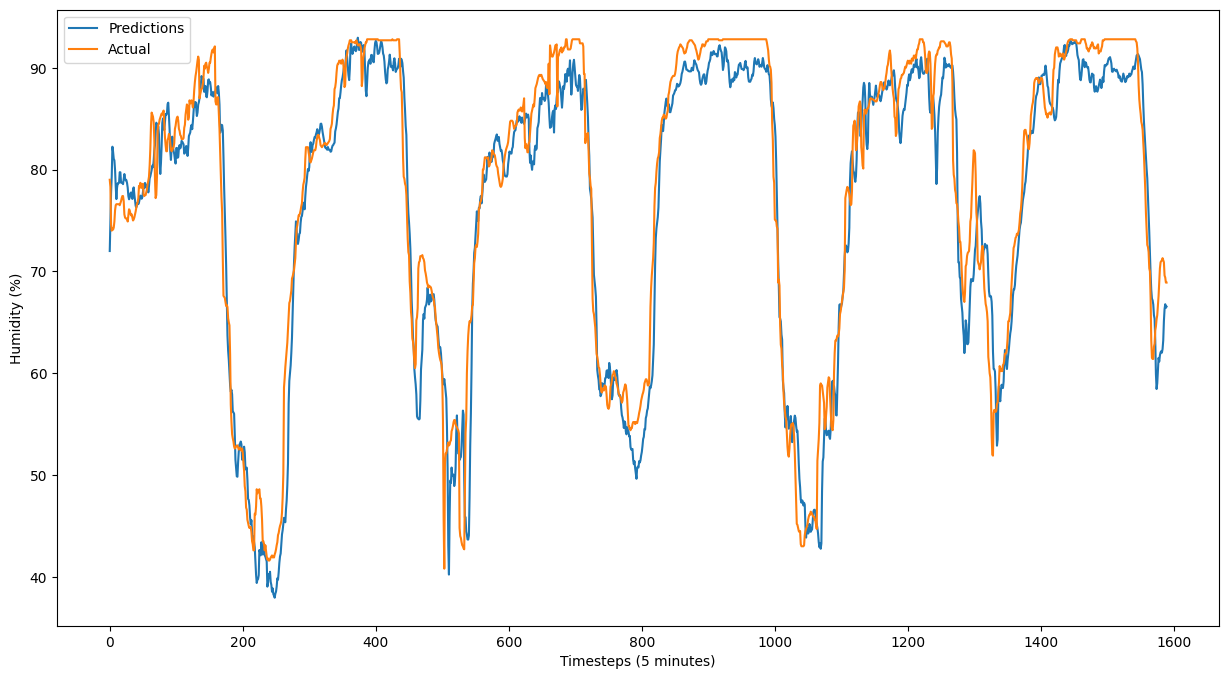

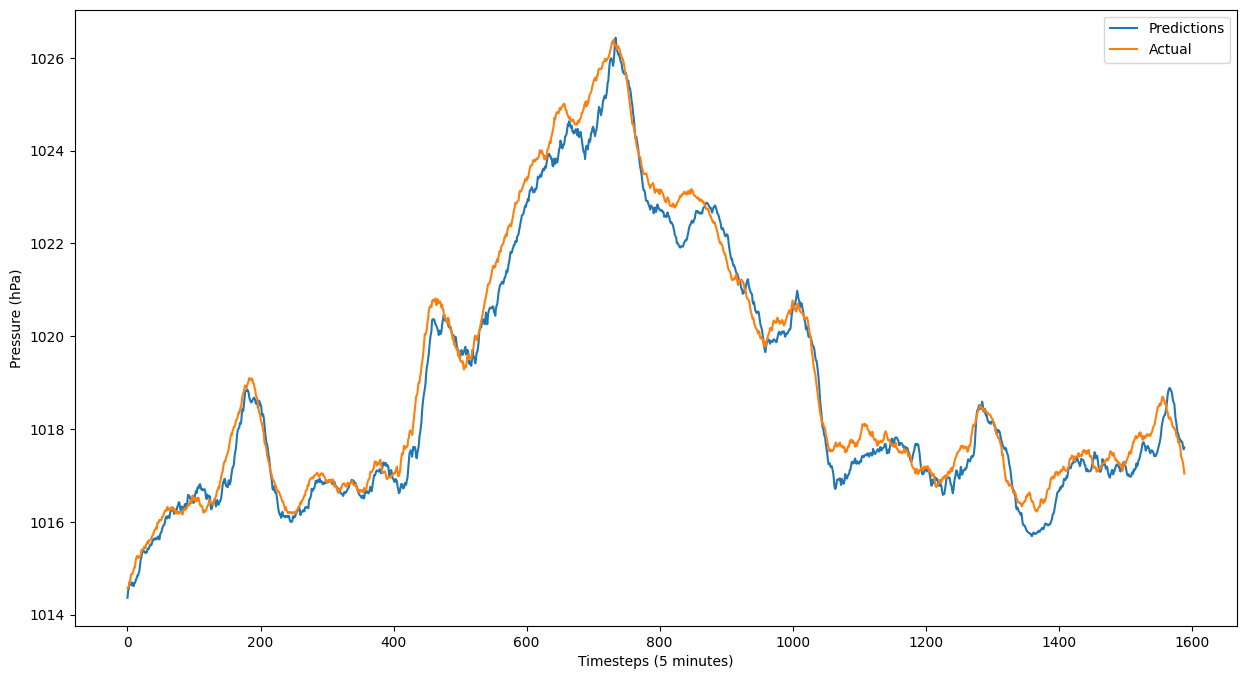

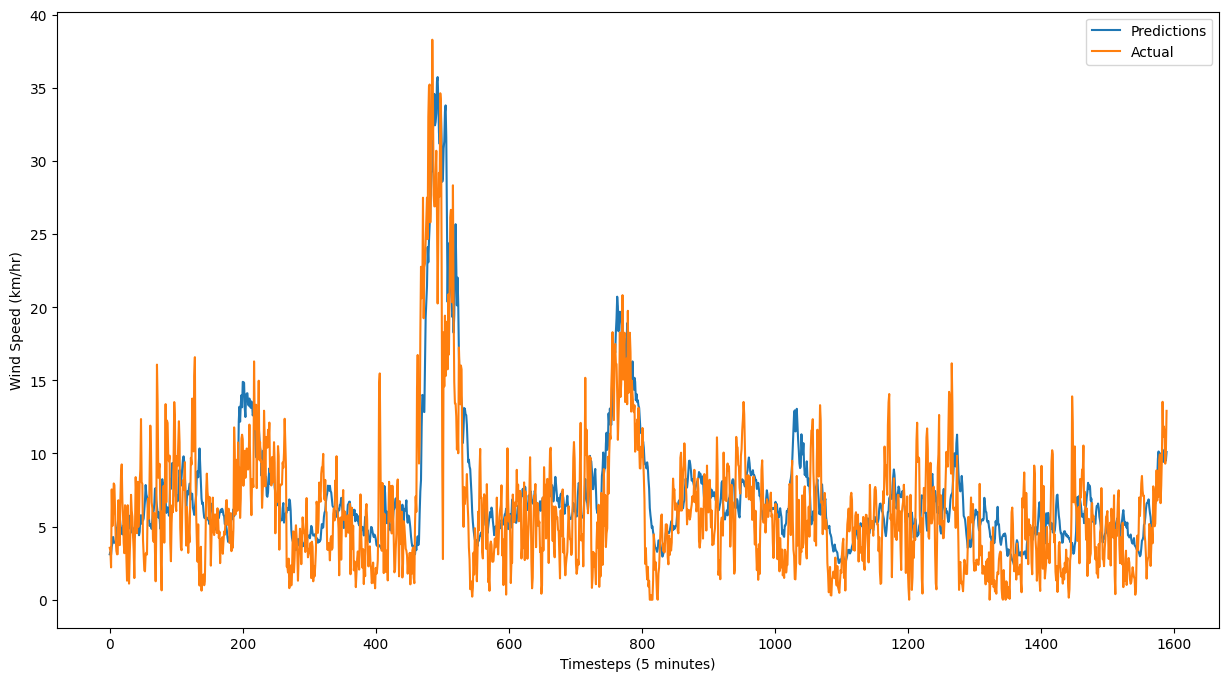

In [11]:
# make redictions on the testing set -> test for overfitting
test_pred  = model.predict(test_X)
test_pred = scaler.inverse_transform(test_pred)
test_y_i  = scaler.inverse_transform(test_y)

# plot results for testing
plt.figure(figsize=(15,8))
plt.plot(test_pred[:,0])
plt.plot(test_y_i[:,0])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Temperature (*C)")
plt.legend(['Predictions', 'Actual'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(test_pred[:,1])
plt.plot(test_y_i[:,1])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Humidity (%)")
plt.legend(['Predictions', 'Actual'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(test_pred[:,2])
plt.plot(test_y_i[:,2])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Pressure (hPa)")
plt.legend(['Predictions', 'Actual'])
plt.show()

plt.figure(figsize=(15,8))
plt.plot(test_pred[:,3])
plt.plot(test_y_i[:,3])
plt.xlabel("Timesteps (5 minutes)")
plt.ylabel("Wind Speed (km/hr)")
plt.legend(['Predictions', 'Actual'])
plt.show()

In [12]:
# score
e1 = mean_absolute_error(test_y_i[:,0], test_pred[:, 0])
e2 = mean_absolute_error(test_y_i[:,1], test_pred[:, 1])
e3 = mean_absolute_error(test_y_i[:,2], test_pred[:, 2])
e4 = mean_absolute_error(test_y_i[:,3], test_pred[:, 3])

mse1 = mean_squared_error(test_y_i[:,0], test_pred[:, 0])
mse2 = mean_squared_error(test_y_i[:,1], test_pred[:, 1])
mse3 = mean_squared_error(test_y_i[:,2], test_pred[:, 2])
mse4 = mean_squared_error(test_y_i[:,3], test_pred[:, 3])

print('Mean Absolute Error for Temperature : ', round(e1, 2))
print('Mean Absolute Error for Humidity    : ', round(e2, 2))
print('Mean Absolute Error for Pressure    : ', round(e3, 2))
print('Mean Absolute Error for Speed       : ', round(e4, 2))

print('Mean Squared Error for Temperature : ', round(mse1, 2))
print('Mean Squared Error for Humidity    : ', round(mse2, 2))
print('Mean Squared Error for Pressure    : ', round(mse3, 2))
print('Mean Squared Error for Pressure    : ', round(mse4, 2))

Mean Absolute Error for Temperature :  0.86
Mean Absolute Error for Humidity    :  3.12
Mean Absolute Error for Pressure    :  0.35
Mean Absolute Error for Speed       :  2.76
Mean Squared Error for Temperature :  1.36
Mean Squared Error for Humidity    :  17.33
Mean Squared Error for Pressure    :  0.2
Mean Squared Error for Pressure    :  13.19


In [13]:
model.save("lstm-30min.keras")
model_1 = keras.models.load_model("lstm-30min.keras",compile=True)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            90624     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 140292 (548.02 KB)
Trainable params: 140292 (548.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
